In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from calendar import monthrange
from glob import glob
import pickle
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# fp = '/scratch1/RDARCH/rda-ghpcs/Rey.Koki/SmokeViz_code/deep_learning/dataset_pointers/smokeviz_yr_split/SmokeViz.pkl'
fp  = '/scratch1/RDARCH/rda-ghpcs/Rey.Koki/SmokeViz_code/deep_learning/dataset_pointers/pseudo/pseudo.pkl'
with open(fp, 'rb') as handle:
    data_dict = pickle.load(handle)

### Sample count per density per year


In [40]:
train_yr = ['2018', '2019', '2020', '2021', '2024']
val_yr = ['2023']
test_yr = ['2022']
all_yr = (train_yr + val_yr + test_yr)
all_yr.sort()
num_yr = len(all_yr)
print(all_yr)

['2018', '2019', '2020', '2021', '2022', '2023', '2024']


In [4]:
data_dict['train']['truth'][0]

'/scratch1/RDARCH/rda-ghpcs/Rey.Koki/PL2/truth/2018/Light/183/G16_s20181832300405_40.6_-121.94_40.tif'

In [41]:
truth_dir = '/scratch1/RDARCH/rda-ghpcs/Rey.Koki/PL2/truth/' #'/scratch1/RDARCH/rda-ghpcs/Rey.Koki/SmokeViz/truth/'
sample_counts = pd.DataFrame({'Light' : np.zeros(num_yr),
                              'Medium': np.zeros(num_yr),
                              'Heavy' : np.zeros(num_yr)},
                             index=all_yr)
for yr in sample_counts.index:
    for density in list(sample_counts):
        datenums = os.listdir("{}{}/{}/".format(truth_dir, yr, density))
        for dn in datenums:   
            num_samples =  len(os.listdir("{}{}/{}/{}/".format(truth_dir, yr, density, dn)))
            sample_counts.loc[yr, density] = sample_counts.loc[yr, density] + num_samples
print(sample_counts)

        Light  Medium   Heavy
2018  26635.0  4489.0  2291.0
2019  26249.0  6203.0  3202.0
2020  29163.0  7086.0  3634.0
2021  15783.0  5006.0  3747.0
2022  12725.0  5136.0  2363.0
2023  11124.0  5136.0  2963.0
2024   7076.0  2654.0  1007.0


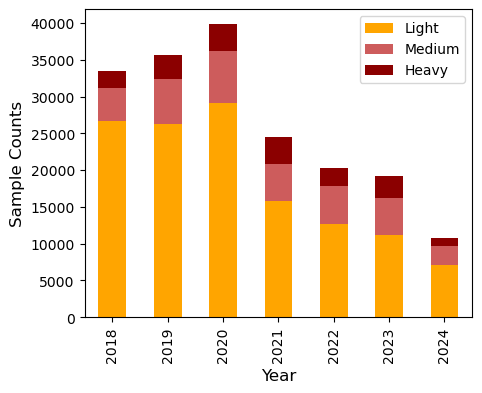

In [6]:
sample_counts.plot(figsize=(5,4),kind='bar', stacked=True, color=['orange', 'indianred', 'darkred'])
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sample Counts', fontsize=12)
plt.savefig('figures/sample_count_per_yr.png', bbox_inches='tight', dpi=300)

### Sample Count Per Density Per Month of the Year 

In [7]:
month_counts = pd.DataFrame({'2018' : [0]*12, '2019' : [0]*12, '2020' : [0]*12, '2021' : [0]*12, '2022' : [0]*12, '2023' : [0]*12},
                             index = list(range(1,13)))
for yr in list(month_counts):
    curr_dn = 0
    for month in month_counts.index:
        days = monthrange(int(yr), int(month))
        for day in range(1,days[1]+1):
            curr_dn += 1
            dn_str = str(curr_dn).zfill(3)
            num_dn_samples =  len(glob("{}{}/*/{}/*tif".format(truth_dir, yr, dn_str)))
            month_counts.loc[month, yr] += num_dn_samples

In [8]:
month_counts

,2018,2019,2020,2021,2022,2023
1,2434,1877,3494,1411,2363,1405
2,1039,1675,4303,1799,2190,1715
3,6340,4222,6590,3580,3358,2967
4,6056,4258,5107,3990,2262,1575
5,2882,3276,3892,2379,1321,1559
6,2675,2647,2636,2032,1265,2011
7,2585,2525,2538,2445,1068,1197
8,2612,2974,3098,1944,1503,1622
9,2089,3250,1841,1344,1347,1412
10,2325,3598,2949,1312,2189,1800


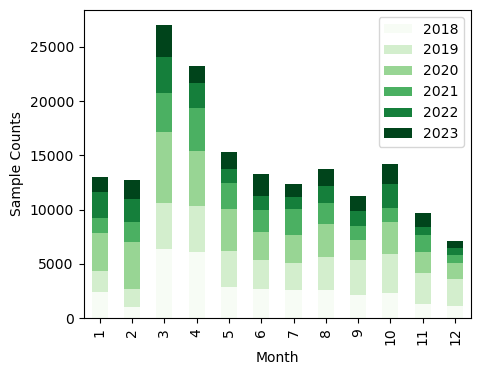

In [9]:
month_counts.plot(figsize=(5,4), kind='bar', stacked=True, cmap='Greens')
plt.xlabel('Month')
plt.ylabel('Sample Counts')
plt.savefig('figures/sample_count_per_month.png', bbox_inches='tight', dpi=300)

### Sample count per area - US state and North American country

In [22]:
lat_lon_pkl = './geo_dependent/dict_lat_lon_fn.pkl'
with open(lat_lon_pkl, 'rb') as handle:
    lat_lon_dict = pickle.load(handle)
states = geopandas.read_file('./shape_files/states.shp')
countries = geopandas.read_file('./shape_files/NA_countries.shp')

lat_lon_df = pd.DataFrame(lat_lon_dict)
geometry= geopandas.points_from_xy(x=lat_lon_df['Longitude'],y=lat_lon_df['Latitude'], crs=states.crs)
gdf=geopandas.GeoDataFrame(lat_lon_df, geometry=geometry)

In [23]:
len(lat_lon_dict['Latitude']), len(lat_lon_dict['Longitude'])

(183672, 183672)

In [24]:
states_dict = {}
for idx, row in states.iterrows():                                                                                                                       
    state_dict = {row['shapeISO']: 0}
    states_dict.update(state_dict)
countries_dict = {}
for idx, row in countries.iterrows():                                                                                                                       
    country_dict = {row['shapeISO']: 0}
    countries_dict.update(country_dict)

In [26]:
for idx, row in states.iterrows():
    states_dict[row['shapeISO']] = len(gdf.geometry.clip(row['geometry']))
for idx, row in countries.iterrows():
    countries_dict[row['shapeISO']] = len(gdf.geometry.clip(row['geometry']))

In [27]:
print(countries_dict)

{'CAN': 18461, 'MEX': 25014, 'USA': 115311}


In [28]:
print(state_dict)

{'US-CT': 0}


In [30]:
def assign_state_smoke_count(states):    
    count = states_dict[states['shapeISO']]
    states['smoke_count'] = count                                                                                                                                         
    return states
states = states.apply(assign_state_smoke_count, axis=1)
def assign_country_smoke_count(countries):    
    count = countries_dict[countries['shapeISO']]
    countries['smoke_count'] = count                                                                                                                                         
    return countries
countries = countries.apply(assign_country_smoke_count, axis=1)

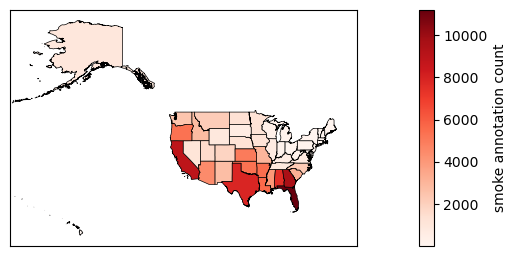

In [31]:
color = 'Reds'
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-.1)
states.plot(figsize=(5,4), column='smoke_count', cmap=color, edgecolor='black', linewidth=.5, ax=ax, legend=True, cax=cax, legend_kwds={'label': "smoke annotation count",'orientation': "vertical"})
ax.get_yaxis().set_visible(False)                                                                                                                        
ax.get_xaxis().set_visible(False)   
ax.set_xlim(-180,-60)
plt.savefig('figures/sample_count_per_state.png', bbox_inches='tight', dpi=300)                                                                           

plt.show()
#ax.set_title('Count of Smoke Annotations')                                                                                            
#plt.close()         

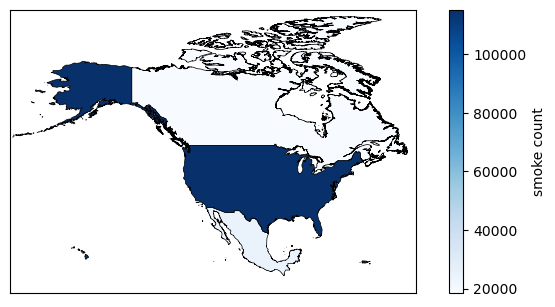

In [32]:
color = 'Blues'
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-.1)
countries.plot(column='smoke_count', cmap=color, edgecolor='black', linewidth=.5, ax=ax, legend=True, cax=cax, legend_kwds={'label': "smoke count",'orientation': "vertical"})
ax.get_yaxis().set_visible(False)                                                                                                                        
ax.get_xaxis().set_visible(False)   
ax.set_xlim(-180,-50)
ax.set_ylim(10,85)
plt.savefig('figures/sample_count_per_country.png', bbox_inches='tight',dpi=300)                                                                           

plt.show()

## Model Perfomance Statistics

### variations in model performance on testset over the year

how does IoU change based on month of year the data is taken from?

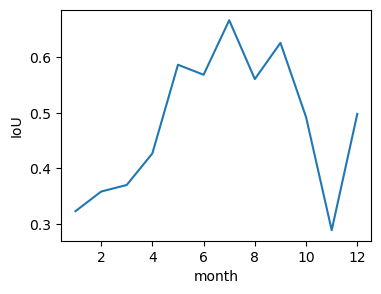

In [44]:
month_IoU = [0.3228, 0.3581, 0.37003, 0.42687, 0.58674, 0.56869, 0.667, 0.5609, 0.6262, 0.4923, 0.28844, 0.49818]

fig = plt.figure(figsize=(4, 3))
plt.plot( list(range(1,13)), month_IoU)
plt.xlabel('month')
plt.ylabel('IoU')
plt.savefig('figures/IoU_per_month.png', bbox_inches='tight',dpi=300)                                                                           

plt.show()

### Geographical variations in model performance

we separate into 4 regions based on the mid-point (40, -100) and run the model on each sub-testset

In [37]:
total_geo_counts = {'NW': 0, 'SW': 0, 'NE': 0, 'SE': 0}

def count_section(lat, lon):
    if lat >= 40 and lon <= -100:
        total_geo_counts['NW']+=1
    elif lat < 40 and lon <= -100:
        total_geo_counts['SW']+=1
    elif lat >= 40 and lon > -100:
        total_geo_counts['NE']+=1
    elif lat < 40 and lon > -100:
        total_geo_counts['SE']+=1

for idx, row in lat_lon_df.iterrows():
    count_section(row['Latitude'], row['Longitude'])

In [36]:
print(geo_counts) 

{'NW': 32792, 'SW': 34267, 'NE': 13342, 'SE': 103271}


number test samples:
NW:  4177
SW:  1937
NE:  1133
SE:  12977

geo region testing results:

Region: NW
OVERALL HIGH DENSITY SMOKE GIVES: 0.37266042828559875 IoU
OVERALL MEDIUM DENSITY SMOKE GIVES: 0.5135848522186279 IoU
OVERALL LOW DENSITY SMOKE GIVES: 0.6784210801124573 IoU
OVERALL OVER ALL DENSITY GIVES: 0.5997581481933594


Region: SW
OVERALL HIGH DENSITY SMOKE GIVES: 0.36138588190078735 IoU
OVERALL MEDIUM DENSITY SMOKE GIVES: 0.41685912013053894 IoU
OVERALL LOW DENSITY SMOKE GIVES: 0.5756829977035522 IoU
OVERALL OVER ALL DENSITY GIVES: 0.5318014621734619

Region: NE
OVERALL HIGH DENSITY SMOKE GIVES: 0.37252068519592285 IoU
OVERALL MEDIUM DENSITY SMOKE GIVES: 0.5160619020462036 IoU
OVERALL LOW DENSITY SMOKE GIVES: 0.6909656524658203 IoU
OVERALL OVER ALL DENSITY GIVES: 0.6149010062217712

Region: SE
OVERALL HIGH DENSITY SMOKE GIVES: 0.2852378487586975 IoU
OVERALL MEDIUM DENSITY SMOKE GIVES: 0.25603896379470825 IoU
OVERALL LOW DENSITY SMOKE GIVES: 0.48183804750442505 IoU
OVERALL OVER ALL DENSITY GIVES: 0.4375208020210266

[0.5998, 0.5318, 0.6149, 0.4375] IoU IoU IoU IoU


| Geographical region | Overall testset IoU | Number test samples | Total number of samples |
| -------- | ------- |  ------- |  ------- | 
| NW | 0.5998 | 4177 | 32792 |
| SW | 0.5318 | 1937 | 34267 |
| NE | 0.6149 | 1133 | 13342 |
| SE | 0.4375 | 12977 | 103271 |

### Satellite source variation in model performance

Are there variations in model performance depending on which satellite the data is sourced from

In [43]:
sat_counts = {'G16' : 0, 'G17': 0 }
densities = ['Heavy', 'Medium', 'Light']
for density in densities:
    sat_counts['G16']+=len(glob('{}/*/{}/*/G16_*.tif'.format(truth_dir,density)))
    sat_counts['G17']+=len(glob('{}/*/{}/*/G17_*.tif'.format(truth_dir,density)))
    sat_counts['G17']+=len(glob('{}/*/{}/*/G18_*.tif'.format(truth_dir,density)))

print(sat_counts)

{'G16': 143640, 'G17': 40032}



| Satellite | Overall Test Set IoU | Number Test Samples | Total number of samples in full dataset|
| -------- | ------- |  ------- |  ------- | 
| GOES-WEST | 0.6450 | 1827 | 30640 |
| GOES-EAST | 0.4827 | 5647 | 119040 |

### Temporal proximity to sunrise/sunset

| time difference | Mie DS IoU | PL DS IoU|
| -------- | ------- | ------- |
| <2 hours  | 0.412 | 0.546 |
| >2 hours  |  0.411 | 0.538 |

shows the overall IoU values for the Mie or pseudo-labeled test dataset samples that are within or outside 2 hours of either sunrise or sunset.

### Sample count proximity to sunrise/sunset for Mie vs pseudo-label derived datasets

| time difference | Mie DS | PL DS |
| -------- | ------- | ------- |
| <2 hours  | 3923 (63%) | 3436 (46%) |
| >2 hours  | 2280 (37%) | 4038 (54%) |

shows the split on if the Mie or pseudo-labeled test dataset samples that are within or outside 2 hours of either sunrise or sunset. The Mie dataset is skewed towards the nighttime boundaries. 
